### This notebook shows the training of SRCNN(Super resolution convolutional neural network) to generate super resolution images.<br>
** The median images generated from statistical experimentation are used as input images for the network**

In [17]:
from core import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam
import os
import matplotlib.pyplot as plt
import time
import glob

In [14]:
DATA_PATH = "../Data/Median_images"

**Loading input images(low resolution images) and target images(high resolution images)**

In [3]:
Y_imgs_path = [path for path in glob.glob(DATA_PATH + "/*_HR.png")]
X_imgs_path = [path[:-7] + ".png" for path in Y_imgs_path]

In [7]:
X_imgs = np.array([skimage.img_as_float64(load_image(path, dtype=np.uint16)) for path in X_imgs_path])
Y_imgs = np.array([skimage.img_as_float64(load_image(path, dtype=np.uint16)) for path in Y_imgs_path])

**Reshaping images in Channel last form for training with SRCNN**

In [8]:
X_imgs = X_imgs.reshape(X_imgs.shape[0],X_imgs.shape[1],X_imgs.shape[2],1) #channel last form: (Batch_size, width, height,channel)
Y_imgs = Y_imgs.reshape(Y_imgs.shape[0],Y_imgs.shape[1],Y_imgs.shape[2],1)


**Calling the defined SRCNN model and loading weights for transfer learning**

In [9]:
srcnn_model = model(X_imgs.shape[1:])

"""
hyperparameters lr and decay are tuned during training for making the algorithm to converge
"""
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.2, amsgrad=False)
srcnn_model.compile(optimizer='adam', loss="mean_squared_error", metrics=['mean_squared_error']) 
srcnn_model.load_weights("../models/SRCNN/weights/weights.h5")   


In [10]:
srcnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 384, 384, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 384, 384, 128)     10496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 384, 384, 64)      73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 384, 384, 1)       1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


**Defining callbacks for saving the best model and for using tensorboard**

In [11]:
checkpoint = ModelCheckpoint("../models/SRCNN/weights/weights.h5", monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

tensorboard_callback = TensorBoard(log_dir="../models/SRCNN/logs/{}".format(time.time()))

callbacks_list = [checkpoint,tensorboard_callback]

**Fitting the model and validating it on 20% of training set.**

In [34]:
srcnn_model.fit(X_imgs, Y_imgs, batch_size=32,validation_split = 0.2, shuffle=True, epochs=200,callbacks=callbacks_list, verbose=1)

Train on 928 samples, validate on 232 samples
Epoch 1/200
928/928 [==============================] - 72s 78ms/step - loss: 9.0856e-04 - mean_squared_error: 9.0856e-04 - val_loss: 1.3659e-04 - val_mean_squared_error: 1.3659e-04

Epoch 00001: loss improved from inf to 0.00091, saving model to ../models/SRCNN/weights/weights.h5
Epoch 2/200
928/928 [==============================] - 66s 71ms/step - loss: 7.6044e-05 - mean_squared_error: 7.6044e-05 - val_loss: 5.3823e-05 - val_mean_squared_error: 5.3823e-05

Epoch 00002: loss improved from 0.00091 to 0.00008, saving model to ../models/SRCNN/weights/weights.h5
Epoch 3/200
928/928 [==============================] - 66s 71ms/step - loss: 5.8783e-05 - mean_squared_error: 5.8783e-05 - val_loss: 5.2200e-05 - val_mean_squared_error: 5.2200e-05

Epoch 00003: loss improved from 0.00008 to 0.00006, saving model to ../models/SRCNN/weights/weights.h5
Epoch 4/200
928/928 [==============================] - 66s 71ms/step - loss: 5.7699e-05 - mean_squared_

KeyboardInterrupt: 

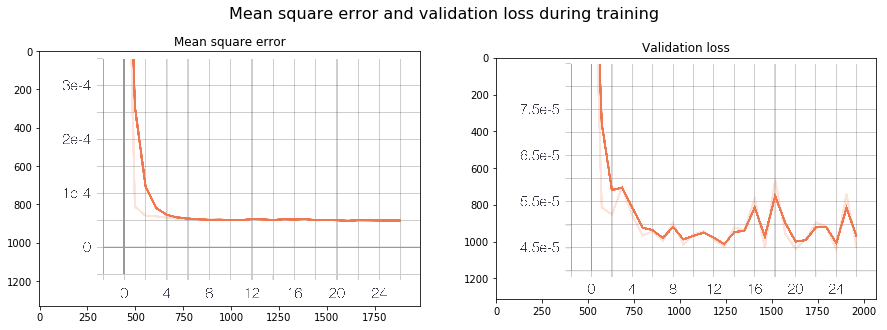

In [23]:
fig=plt.figure(figsize=(15,5))
fig.suptitle('Mean square error and validation loss during training', fontsize=16)

fig.add_subplot(1, 2, 1)
plt.title("Mean square error")
plt.imshow(load_image(path = "../Result/mean_sq_err.png",dtype=np.uint8),cmap=None) 
    
fig.add_subplot(1, 2, 2)
plt.title("Validation loss")
plt.imshow(load_image(path = "../Result/val_loss.png",dtype=np.uint8),cmap=None)
    